# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 50, 50, 50, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Tanh()
    (6): Linear(in_features=50, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 50, 50, 50, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 0.8775
Epoch 1/200, Iteration 2/12, Loss: 0.6350
Epoch 1/200, Iteration 3/12, Loss: 0.5698
Epoch 1/200, Iteration 4/12, Loss: 0.3876
Epoch 1/200, Iteration 5/12, Loss: 0.2877
Epoch 1/200, Iteration 6/12, Loss: 0.3241
Epoch 1/200, Iteration 7/12, Loss: 0.3488
Epoch 1/200, Iteration 8/12, Loss: 0.3149
Epoch 1/200, Iteration 9/12, Loss: 0.3089
Epoch 1/200, Iteration 10/12, Loss: 0.2836
Epoch 1/200, Iteration 11/12, Loss: 0.2956
Epoch 1/200, Iteration 12/12, Loss: 0.2598
Epoch 1/200, Iteration 13/12, Loss: 0.2044
Train Error: 
 Accuracy: 69.5%, Avg loss: 0.241106, MRE: 0.250644, MAE: 0.030631 

Test Error: 
 Accuracy: 77.5%, Avg loss: 0.220349, MRE: 0.192098, MAE: 0.027842 

Epoch 2/200, Iteration 1/12, Loss: 0.2172
Epoch 2/200, Iteration 2/12, Loss: 0.2416
Epoch 2/200, Iteration 3/12, Loss: 0.2135
Epoch 2/200, Iteration 4/12, Loss: 0.2080
Epoch 2/200, Iteration 5/12, Loss: 0.2244
Epoch 2/200, Iteration 6/12, Loss: 0.2041
Epoch 2/200, Iteration 7/12, Loss

Train Error: 
 Accuracy: 89.12%, Avg loss: 0.063968, MRE: 0.052383, MAE: 0.007862 

Test Error: 
 Accuracy: 87.5%, Avg loss: 0.062121, MRE: 0.043404, MAE: 0.007738 

Epoch 13/200, Iteration 1/12, Loss: 0.0760
Epoch 13/200, Iteration 2/12, Loss: 0.0717
Epoch 13/200, Iteration 3/12, Loss: 0.0471
Epoch 13/200, Iteration 4/12, Loss: 0.0528
Epoch 13/200, Iteration 5/12, Loss: 0.0640
Epoch 13/200, Iteration 6/12, Loss: 0.0617
Epoch 13/200, Iteration 7/12, Loss: 0.0753
Epoch 13/200, Iteration 8/12, Loss: 0.0608
Epoch 13/200, Iteration 9/12, Loss: 0.0615
Epoch 13/200, Iteration 10/12, Loss: 0.0611
Epoch 13/200, Iteration 11/12, Loss: 0.0591
Epoch 13/200, Iteration 12/12, Loss: 0.0612
Epoch 13/200, Iteration 13/12, Loss: 0.0778
Train Error: 
 Accuracy: 80.5%, Avg loss: 0.078040, MRE: 0.068215, MAE: 0.010129 

Test Error: 
 Accuracy: 82.0%, Avg loss: 0.069158, MRE: 0.045086, MAE: 0.008898 

Epoch 14/200, Iteration 1/12, Loss: 0.0714
Epoch 14/200, Iteration 2/12, Loss: 0.0653
Epoch 14/200, Iterat

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.035920, MRE: 0.026460, MAE: 0.004542 

Epoch 25/200, Iteration 1/12, Loss: 0.0329
Epoch 25/200, Iteration 2/12, Loss: 0.0449
Epoch 25/200, Iteration 3/12, Loss: 0.0239
Epoch 25/200, Iteration 4/12, Loss: 0.0335
Epoch 25/200, Iteration 5/12, Loss: 0.0365
Epoch 25/200, Iteration 6/12, Loss: 0.0428
Epoch 25/200, Iteration 7/12, Loss: 0.0446
Epoch 25/200, Iteration 8/12, Loss: 0.0379
Epoch 25/200, Iteration 9/12, Loss: 0.0340
Epoch 25/200, Iteration 10/12, Loss: 0.0351
Epoch 25/200, Iteration 11/12, Loss: 0.0452
Epoch 25/200, Iteration 12/12, Loss: 0.0479
Epoch 25/200, Iteration 13/12, Loss: 0.0309
Train Error: 
 Accuracy: 97.12%, Avg loss: 0.046083, MRE: 0.037222, MAE: 0.006483 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.040788, MRE: 0.027415, MAE: 0.005647 

Epoch 26/200, Iteration 1/12, Loss: 0.0459
Epoch 26/200, Iteration 2/12, Loss: 0.0506
Epoch 26/200, Iteration 3/12, Loss: 0.0445
Epoch 26/200, Iteration 4/12, Loss: 0.0540
Epoch 26/200, Ite

Epoch 36/200, Iteration 9/12, Loss: 0.0373
Epoch 36/200, Iteration 10/12, Loss: 0.0346
Epoch 36/200, Iteration 11/12, Loss: 0.0399
Epoch 36/200, Iteration 12/12, Loss: 0.0474
Epoch 36/200, Iteration 13/12, Loss: 0.0558
Train Error: 
 Accuracy: 94.12%, Avg loss: 0.043565, MRE: 0.039294, MAE: 0.005853 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.040883, MRE: 0.030417, MAE: 0.005577 

Epoch 37/200, Iteration 1/12, Loss: 0.0446
Epoch 37/200, Iteration 2/12, Loss: 0.0471
Epoch 37/200, Iteration 3/12, Loss: 0.0477
Epoch 37/200, Iteration 4/12, Loss: 0.0577
Epoch 37/200, Iteration 5/12, Loss: 0.0577
Epoch 37/200, Iteration 6/12, Loss: 0.0526
Epoch 37/200, Iteration 7/12, Loss: 0.0536
Epoch 37/200, Iteration 8/12, Loss: 0.0498
Epoch 37/200, Iteration 9/12, Loss: 0.0476
Epoch 37/200, Iteration 10/12, Loss: 0.0432
Epoch 37/200, Iteration 11/12, Loss: 0.0439
Epoch 37/200, Iteration 12/12, Loss: 0.0498
Epoch 37/200, Iteration 13/12, Loss: 0.0458
Train Error: 
 Accuracy: 92.12%, Avg loss: 0.067396,

Train Error: 
 Accuracy: 99.0%, Avg loss: 0.015987, MRE: 0.014544, MAE: 0.002124 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.014673, MRE: 0.011401, MAE: 0.001927 

Epoch 48/200, Iteration 1/12, Loss: 0.0198
Epoch 48/200, Iteration 2/12, Loss: 0.0171
Epoch 48/200, Iteration 3/12, Loss: 0.0186
Epoch 48/200, Iteration 4/12, Loss: 0.0194
Epoch 48/200, Iteration 5/12, Loss: 0.0158
Epoch 48/200, Iteration 6/12, Loss: 0.0154
Epoch 48/200, Iteration 7/12, Loss: 0.0156
Epoch 48/200, Iteration 8/12, Loss: 0.0139
Epoch 48/200, Iteration 9/12, Loss: 0.0130
Epoch 48/200, Iteration 10/12, Loss: 0.0142
Epoch 48/200, Iteration 11/12, Loss: 0.0136
Epoch 48/200, Iteration 12/12, Loss: 0.0147
Epoch 48/200, Iteration 13/12, Loss: 0.0145
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.012857, MRE: 0.013258, MAE: 0.001639 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.011932, MRE: 0.010049, MAE: 0.001488 

Epoch 49/200, Iteration 1/12, Loss: 0.0133
Epoch 49/200, Iteration 2/12, Loss: 0.0129
Epoch 49/200, Iterat

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.009655, MRE: 0.008108, MAE: 0.001194 

Epoch 60/200, Iteration 1/12, Loss: 0.0115
Epoch 60/200, Iteration 2/12, Loss: 0.0115
Epoch 60/200, Iteration 3/12, Loss: 0.0136
Epoch 60/200, Iteration 4/12, Loss: 0.0106
Epoch 60/200, Iteration 5/12, Loss: 0.0083
Epoch 60/200, Iteration 6/12, Loss: 0.0123
Epoch 60/200, Iteration 7/12, Loss: 0.0103
Epoch 60/200, Iteration 8/12, Loss: 0.0153
Epoch 60/200, Iteration 9/12, Loss: 0.0119
Epoch 60/200, Iteration 10/12, Loss: 0.0124
Epoch 60/200, Iteration 11/12, Loss: 0.0121
Epoch 60/200, Iteration 12/12, Loss: 0.0104
Epoch 60/200, Iteration 13/12, Loss: 0.0095
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.011719, MRE: 0.012297, MAE: 0.001472 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.012071, MRE: 0.009849, MAE: 0.001456 

Epoch 61/200, Iteration 1/12, Loss: 0.0117
Epoch 61/200, Iteration 2/12, Loss: 0.0117
Epoch 61/200, Iteration 3/12, Loss: 0.0078
Epoch 61/200, Iteration 4/12, Loss: 0.0085
Epoch 61/200, It

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.009946, MRE: 0.010247, MAE: 0.001288 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.009481, MRE: 0.007662, MAE: 0.001196 

Epoch 72/200, Iteration 1/12, Loss: 0.0100
Epoch 72/200, Iteration 2/12, Loss: 0.0083
Epoch 72/200, Iteration 3/12, Loss: 0.0110
Epoch 72/200, Iteration 4/12, Loss: 0.0088
Epoch 72/200, Iteration 5/12, Loss: 0.0095
Epoch 72/200, Iteration 6/12, Loss: 0.0093
Epoch 72/200, Iteration 7/12, Loss: 0.0077
Epoch 72/200, Iteration 8/12, Loss: 0.0067
Epoch 72/200, Iteration 9/12, Loss: 0.0086
Epoch 72/200, Iteration 10/12, Loss: 0.0140
Epoch 72/200, Iteration 11/12, Loss: 0.0123
Epoch 72/200, Iteration 12/12, Loss: 0.0105
Epoch 72/200, Iteration 13/12, Loss: 0.0083
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.010886, MRE: 0.012313, MAE: 0.001432 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.010492, MRE: 0.008310, MAE: 0.001324 

Epoch 73/200, Iteration 1/12, Loss: 0.0079
Epoch 73/200, Iteration 2/12, Loss: 0.0089
Epoch 73/200, Ite

Epoch 84/200, Iteration 13/12, Loss: 0.0116
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.009091, MRE: 0.009136, MAE: 0.001195 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.009215, MRE: 0.007111, MAE: 0.001187 

Epoch 85/200, Iteration 1/12, Loss: 0.0098
Epoch 85/200, Iteration 2/12, Loss: 0.0061
Epoch 85/200, Iteration 3/12, Loss: 0.0063
Epoch 85/200, Iteration 4/12, Loss: 0.0100
Epoch 85/200, Iteration 5/12, Loss: 0.0090
Epoch 85/200, Iteration 6/12, Loss: 0.0083
Epoch 85/200, Iteration 7/12, Loss: 0.0080
Epoch 85/200, Iteration 8/12, Loss: 0.0109
Epoch 85/200, Iteration 9/12, Loss: 0.0110
Epoch 85/200, Iteration 10/12, Loss: 0.0088
Epoch 85/200, Iteration 11/12, Loss: 0.0075
Epoch 85/200, Iteration 12/12, Loss: 0.0080
Epoch 85/200, Iteration 13/12, Loss: 0.0084
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.009236, MRE: 0.008805, MAE: 0.001171 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.009400, MRE: 0.007472, MAE: 0.001178 

Epoch 86/200, Iteration 1/12, Loss: 0.0107
Epoch 86/200, It

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.008525, MRE: 0.009252, MAE: 0.001097 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.007563, MRE: 0.006492, MAE: 0.000991 

Epoch 97/200, Iteration 1/12, Loss: 0.0069
Epoch 97/200, Iteration 2/12, Loss: 0.0068
Epoch 97/200, Iteration 3/12, Loss: 0.0085
Epoch 97/200, Iteration 4/12, Loss: 0.0068
Epoch 97/200, Iteration 5/12, Loss: 0.0087
Epoch 97/200, Iteration 6/12, Loss: 0.0095
Epoch 97/200, Iteration 7/12, Loss: 0.0066
Epoch 97/200, Iteration 8/12, Loss: 0.0078
Epoch 97/200, Iteration 9/12, Loss: 0.0086
Epoch 97/200, Iteration 10/12, Loss: 0.0068
Epoch 97/200, Iteration 11/12, Loss: 0.0099
Epoch 97/200, Iteration 12/12, Loss: 0.0067
Epoch 97/200, Iteration 13/12, Loss: 0.0091
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.007610, MRE: 0.007655, MAE: 0.000998 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.007759, MRE: 0.006507, MAE: 0.001007 

Epoch 98/200, Iteration 1/12, Loss: 0.0090
Epoch 98/200, Iteration 2/12, Loss: 0.0083
Epoch 98/200, Ite

Epoch 108/200, Iteration 8/12, Loss: 0.0110
Epoch 108/200, Iteration 9/12, Loss: 0.0088
Epoch 108/200, Iteration 10/12, Loss: 0.0072
Epoch 108/200, Iteration 11/12, Loss: 0.0107
Epoch 108/200, Iteration 12/12, Loss: 0.0092
Epoch 108/200, Iteration 13/12, Loss: 0.0111
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.008299, MRE: 0.008191, MAE: 0.001072 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008421, MRE: 0.006881, MAE: 0.001075 

Epoch 109/200, Iteration 1/12, Loss: 0.0068
Epoch 109/200, Iteration 2/12, Loss: 0.0106
Epoch 109/200, Iteration 3/12, Loss: 0.0068
Epoch 109/200, Iteration 4/12, Loss: 0.0070
Epoch 109/200, Iteration 5/12, Loss: 0.0071
Epoch 109/200, Iteration 6/12, Loss: 0.0055
Epoch 109/200, Iteration 7/12, Loss: 0.0063
Epoch 109/200, Iteration 8/12, Loss: 0.0065
Epoch 109/200, Iteration 9/12, Loss: 0.0086
Epoch 109/200, Iteration 10/12, Loss: 0.0091
Epoch 109/200, Iteration 11/12, Loss: 0.0060
Epoch 109/200, Iteration 12/12, Loss: 0.0045
Epoch 109/200, Iteration 13/12, Lo

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005877, MRE: 0.005468, MAE: 0.000736 

Epoch 120/200, Iteration 1/12, Loss: 0.0065
Epoch 120/200, Iteration 2/12, Loss: 0.0084
Epoch 120/200, Iteration 3/12, Loss: 0.0043
Epoch 120/200, Iteration 4/12, Loss: 0.0046
Epoch 120/200, Iteration 5/12, Loss: 0.0055
Epoch 120/200, Iteration 6/12, Loss: 0.0063
Epoch 120/200, Iteration 7/12, Loss: 0.0055
Epoch 120/200, Iteration 8/12, Loss: 0.0082
Epoch 120/200, Iteration 9/12, Loss: 0.0057
Epoch 120/200, Iteration 10/12, Loss: 0.0050
Epoch 120/200, Iteration 11/12, Loss: 0.0058
Epoch 120/200, Iteration 12/12, Loss: 0.0061
Epoch 120/200, Iteration 13/12, Loss: 0.0070
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005864, MRE: 0.006535, MAE: 0.000754 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005961, MRE: 0.005506, MAE: 0.000744 

Epoch 121/200, Iteration 1/12, Loss: 0.0058
Epoch 121/200, Iteration 2/12, Loss: 0.0050
Epoch 121/200, Iteration 3/12, Loss: 0.0047
Epoch 121/200, Iteration 4/12, Loss: 0.005

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005897, MRE: 0.005481, MAE: 0.000734 

Epoch 132/200, Iteration 1/12, Loss: 0.0049
Epoch 132/200, Iteration 2/12, Loss: 0.0048
Epoch 132/200, Iteration 3/12, Loss: 0.0049
Epoch 132/200, Iteration 4/12, Loss: 0.0053
Epoch 132/200, Iteration 5/12, Loss: 0.0075
Epoch 132/200, Iteration 6/12, Loss: 0.0054
Epoch 132/200, Iteration 7/12, Loss: 0.0080
Epoch 132/200, Iteration 8/12, Loss: 0.0049
Epoch 132/200, Iteration 9/12, Loss: 0.0080
Epoch 132/200, Iteration 10/12, Loss: 0.0061
Epoch 132/200, Iteration 11/12, Loss: 0.0035
Epoch 132/200, Iteration 12/12, Loss: 0.0059
Epoch 132/200, Iteration 13/12, Loss: 0.0044
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005656, MRE: 0.006379, MAE: 0.000724 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005987, MRE: 0.005511, MAE: 0.000744 

Epoch 133/200, Iteration 1/12, Loss: 0.0065
Epoch 133/200, Iteration 2/12, Loss: 0.0056
Epoch 133/200, Iteration 3/12, Loss: 0.0056
Epoch 133/200, Iteration 4/12, Loss: 0.004

Epoch 143/200, Iteration 10/12, Loss: 0.0086
Epoch 143/200, Iteration 11/12, Loss: 0.0049
Epoch 143/200, Iteration 12/12, Loss: 0.0053
Epoch 143/200, Iteration 13/12, Loss: 0.0054
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005589, MRE: 0.006436, MAE: 0.000714 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005748, MRE: 0.005373, MAE: 0.000718 

Epoch 144/200, Iteration 1/12, Loss: 0.0062
Epoch 144/200, Iteration 2/12, Loss: 0.0048
Epoch 144/200, Iteration 3/12, Loss: 0.0039
Epoch 144/200, Iteration 4/12, Loss: 0.0084
Epoch 144/200, Iteration 5/12, Loss: 0.0049
Epoch 144/200, Iteration 6/12, Loss: 0.0046
Epoch 144/200, Iteration 7/12, Loss: 0.0047
Epoch 144/200, Iteration 8/12, Loss: 0.0084
Epoch 144/200, Iteration 9/12, Loss: 0.0066
Epoch 144/200, Iteration 10/12, Loss: 0.0043
Epoch 144/200, Iteration 11/12, Loss: 0.0069
Epoch 144/200, Iteration 12/12, Loss: 0.0034
Epoch 144/200, Iteration 13/12, Loss: 0.0037
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005600, MRE: 0.006398, MAE: 0.00

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005512, MRE: 0.006276, MAE: 0.000706 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005717, MRE: 0.005349, MAE: 0.000715 

Epoch 155/200, Iteration 1/12, Loss: 0.0066
Epoch 155/200, Iteration 2/12, Loss: 0.0067
Epoch 155/200, Iteration 3/12, Loss: 0.0063
Epoch 155/200, Iteration 4/12, Loss: 0.0043
Epoch 155/200, Iteration 5/12, Loss: 0.0057
Epoch 155/200, Iteration 6/12, Loss: 0.0053
Epoch 155/200, Iteration 7/12, Loss: 0.0048
Epoch 155/200, Iteration 8/12, Loss: 0.0060
Epoch 155/200, Iteration 9/12, Loss: 0.0064
Epoch 155/200, Iteration 10/12, Loss: 0.0051
Epoch 155/200, Iteration 11/12, Loss: 0.0054
Epoch 155/200, Iteration 12/12, Loss: 0.0040
Epoch 155/200, Iteration 13/12, Loss: 0.0046
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005550, MRE: 0.006810, MAE: 0.000710 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005785, MRE: 0.005399, MAE: 0.000720 

Epoch 156/200, Iteration 1/12, Loss: 0.0062
Epoch 156/200, Iteration 2/12, Loss: 0.0039
Ep

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005399, MRE: 0.006234, MAE: 0.000692 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005751, MRE: 0.005372, MAE: 0.000717 

Epoch 167/200, Iteration 1/12, Loss: 0.0042
Epoch 167/200, Iteration 2/12, Loss: 0.0078
Epoch 167/200, Iteration 3/12, Loss: 0.0037
Epoch 167/200, Iteration 4/12, Loss: 0.0042
Epoch 167/200, Iteration 5/12, Loss: 0.0053
Epoch 167/200, Iteration 6/12, Loss: 0.0077
Epoch 167/200, Iteration 7/12, Loss: 0.0081
Epoch 167/200, Iteration 8/12, Loss: 0.0053
Epoch 167/200, Iteration 9/12, Loss: 0.0049
Epoch 167/200, Iteration 10/12, Loss: 0.0049
Epoch 167/200, Iteration 11/12, Loss: 0.0059
Epoch 167/200, Iteration 12/12, Loss: 0.0043
Epoch 167/200, Iteration 13/12, Loss: 0.0046
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005668, MRE: 0.006333, MAE: 0.000723 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005749, MRE: 0.005372, MAE: 0.000717 

Epoch 168/200, Iteration 1/12, Loss: 0.0040
Epoch 168/200, Iteration 2/12, Loss: 0.0052
Ep

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005750, MRE: 0.005372, MAE: 0.000717 

Epoch 179/200, Iteration 1/12, Loss: 0.0056
Epoch 179/200, Iteration 2/12, Loss: 0.0046
Epoch 179/200, Iteration 3/12, Loss: 0.0045
Epoch 179/200, Iteration 4/12, Loss: 0.0056
Epoch 179/200, Iteration 5/12, Loss: 0.0059
Epoch 179/200, Iteration 6/12, Loss: 0.0036
Epoch 179/200, Iteration 7/12, Loss: 0.0072
Epoch 179/200, Iteration 8/12, Loss: 0.0056
Epoch 179/200, Iteration 9/12, Loss: 0.0041
Epoch 179/200, Iteration 10/12, Loss: 0.0066
Epoch 179/200, Iteration 11/12, Loss: 0.0071
Epoch 179/200, Iteration 12/12, Loss: 0.0051
Epoch 179/200, Iteration 13/12, Loss: 0.0065
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005602, MRE: 0.006349, MAE: 0.000714 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005750, MRE: 0.005372, MAE: 0.000717 

Epoch 180/200, Iteration 1/12, Loss: 0.0065
Epoch 180/200, Iteration 2/12, Loss: 0.0058
Epoch 180/200, Iteration 3/12, Loss: 0.0036
Epoch 180/200, Iteration 4/12, Loss: 0.005

Epoch 190/200, Iteration 2/12, Loss: 0.0047
Epoch 190/200, Iteration 3/12, Loss: 0.0049
Epoch 190/200, Iteration 4/12, Loss: 0.0050
Epoch 190/200, Iteration 5/12, Loss: 0.0049
Epoch 190/200, Iteration 6/12, Loss: 0.0062
Epoch 190/200, Iteration 7/12, Loss: 0.0043
Epoch 190/200, Iteration 8/12, Loss: 0.0039
Epoch 190/200, Iteration 9/12, Loss: 0.0044
Epoch 190/200, Iteration 10/12, Loss: 0.0064
Epoch 190/200, Iteration 11/12, Loss: 0.0057
Epoch 190/200, Iteration 12/12, Loss: 0.0066
Epoch 190/200, Iteration 13/12, Loss: 0.0092
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005462, MRE: 0.006290, MAE: 0.000699 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005747, MRE: 0.005371, MAE: 0.000717 

Epoch 191/200, Iteration 1/12, Loss: 0.0034
Epoch 191/200, Iteration 2/12, Loss: 0.0037
Epoch 191/200, Iteration 3/12, Loss: 0.0054
Epoch 191/200, Iteration 4/12, Loss: 0.0039
Epoch 191/200, Iteration 5/12, Loss: 0.0072
Epoch 191/200, Iteration 6/12, Loss: 0.0051
Epoch 191/200, Iteration 7/12, Loss: 

#### Plots loss vs Epoch

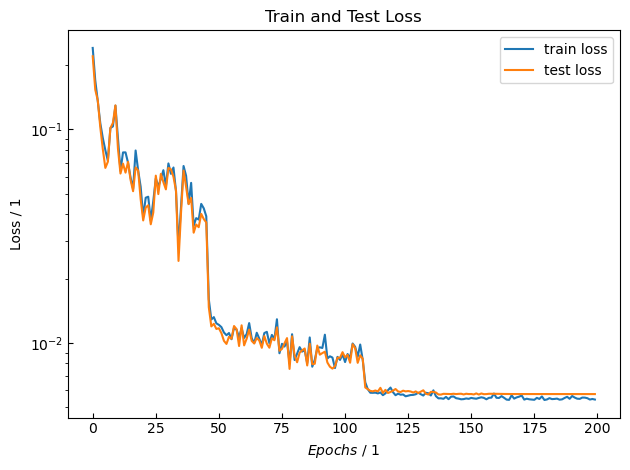

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9998742036553958 , R^2(NH3) = 0.9997221676708273
Test Dataset: R^2(H2) = 0.9999246298560075 , R^2(NH3) = 0.9998704287830741
Max Error Training: |x_H2 - x_H2,pred| = 0.042013512712053 , |x_NH3 - x_NH3,pred| = 0.021536093852205618
Max Error Test: |x_H2 - x_H2,pred| = 0.008959903268403013 , |x_NH3 - x_NH3,pred| = 0.00493809838962711


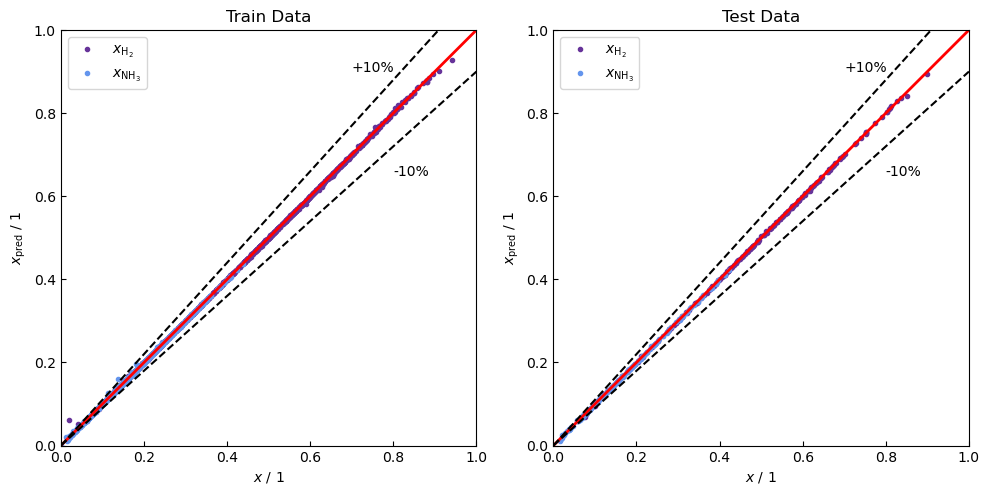

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

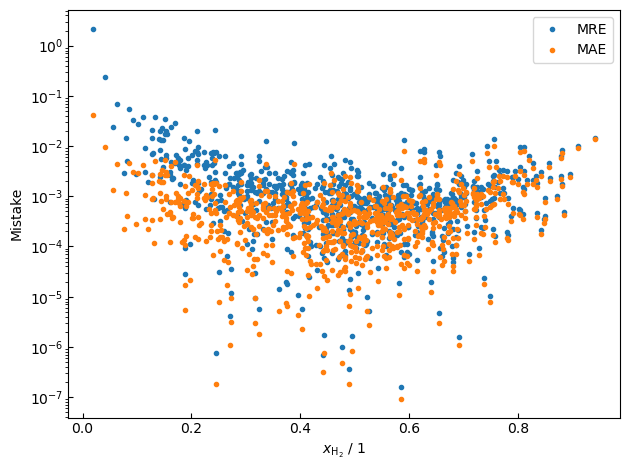

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

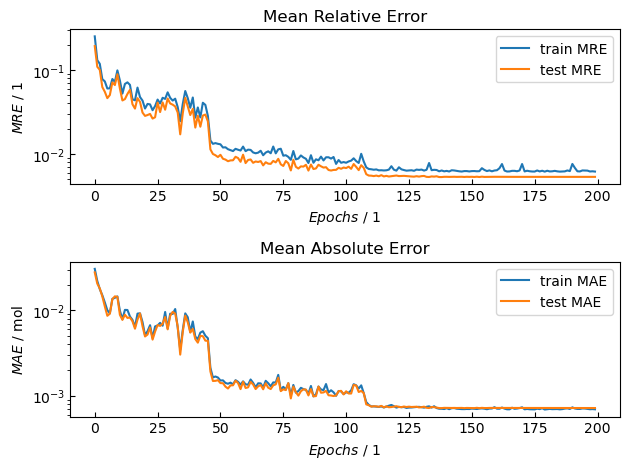

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

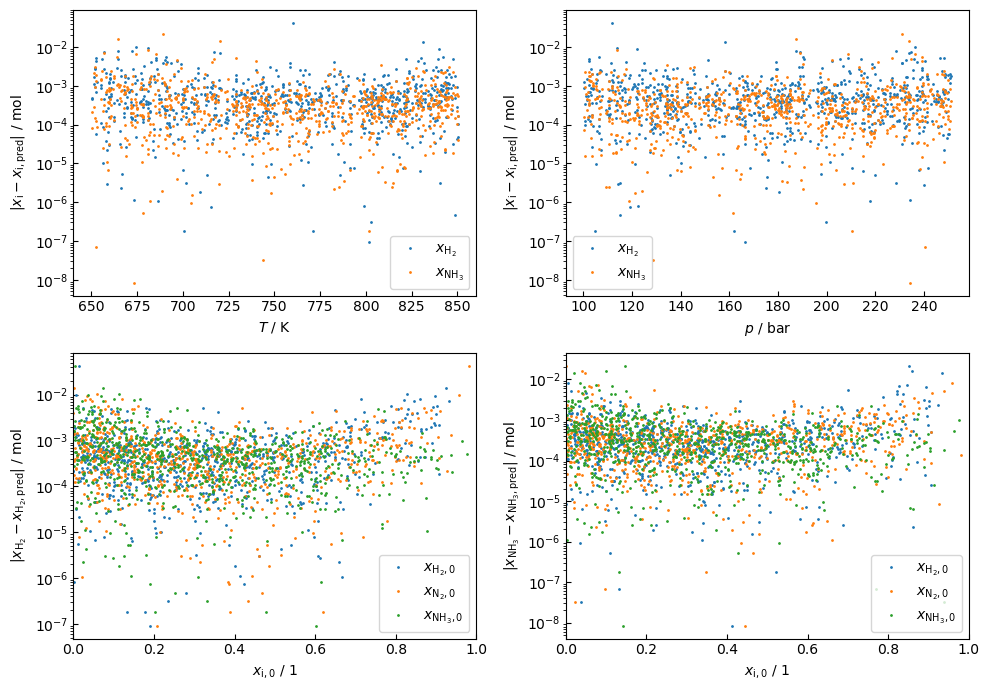

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

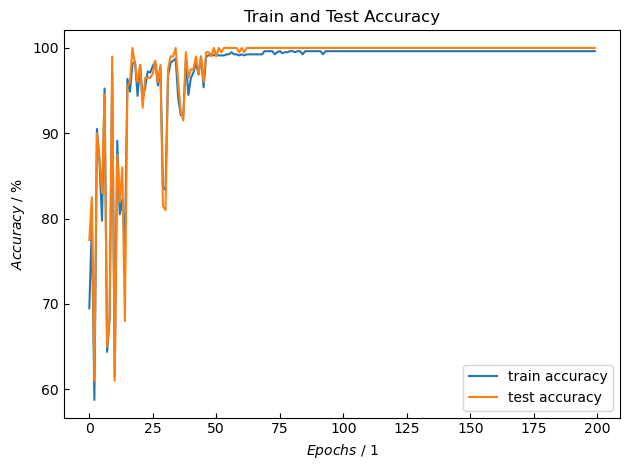

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [16]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-9.3041e-01,  3.3020e-01, -9.4471e-02, -1.1162e+00,  1.2335e+00],
        [-3.0125e-01, -1.6028e+00, -5.5705e-01,  1.3713e+00, -8.5485e-01],
        [ 8.1721e-01,  9.3040e-01, -1.3870e+00, -1.3386e+00,  2.7294e+00],
        [-2.3655e-02,  1.3288e+00,  1.4785e-01, -1.1712e+00,  1.0520e+00],
        [ 1.6201e-01, -1.6405e+00, -8.0775e-01, -1.7207e-01,  9.6858e-01],
        [ 4.5691e-01, -5.5252e-01,  3.0555e-01,  9.5331e-01, -1.2742e+00],
        [-1.5151e-01, -2.1965e-01, -1.3450e+00,  2.0374e+00, -7.6246e-01],
        [ 4.4123e-01, -7.8380e-02, -3.4240e-01,  1.5225e+00, -1.2201e+00],
        [-1.4753e+00, -1.0971e-01, -8.1232e-02, -1.2307e-01,  2.0551e-01],
        [-1.4496e+00,  1.7207e+00, -3.5878e-01, -1.3056e-01,  4.8554e-01],
        [ 6.4162e-01,  9.0515e-02, -4.1377e-01,  2.1817e-01,  1.8308e-01],
        [ 5.3697e-01,  8.2007e-01,  4.3213e-01, -2.7134e-01, -1.4676e-01],
        [-7.3827e-01,  1.5948e+00, -3.1810e-01,  1.6572e+00, -1.3816e+00],
        [ 1.3905e+00, -1.

#### Einblick in Netzwerk

In [17]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 0.0877, -0.0272, -0.1788, -0.2533, -0.1654],
         [-0.2800, -0.0285,  0.0532, -0.2999,  0.2378],
         [ 0.4334, -0.3419, -0.3408, -0.4504, -0.1920],
         [-0.2217, -0.1886, -0.3644,  0.0529, -0.0776],
         [-0.2593, -0.0889, -0.3572, -0.1104, -0.3491],
         [-0.2372,  0.1740, -0.1656,  0.3598, -0.1010],
         [-0.3775,  0.2711, -0.2319,  0.4201,  0.0201],
         [-0.3165, -0.2158, -0.4282, -0.2839, -0.3966],
         [-0.0245,  0.0190,  0.3190,  0.2939,  0.1054],
         [-0.0981,  0.1477,  0.1506,  0.4484,  0.1128],
         [ 0.0081, -0.0765, -0.1032, -0.3488,  0.2469],
         [ 0.1120, -0.1267,  0.3322,  0.1285,  0.4572],
         [ 0.0833, -0.0462, -0.3531,  0.0798, -0.1687],
         [ 0.1521,  0.3828, -0.0118, -0.2731,  0.0870],
         [-0.0119, -0.0784, -0.0937,  0.2554, -0.1378],
         [ 0.0842, -0.0034,  0.1689, -0.3015, -0.2022],
         [-0.3348,  0.2233,  0.3042, -0.0075,  0.2325],
         [-0.0540,  0.197

In [18]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.7977, 0.7871, 0.6670, 0.5651, 0.4449],
        [0.3760, 0.7496, 0.3767, 0.3081, 0.1577]])
tensor([[ 0.1140, -0.0718],
        [ 0.0086,  0.1159]], grad_fn=<AddmmBackward0>)


In [19]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [20]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 1.1709e+00,  1.4049e+00, -1.1886e+00,  8.9980e-01,  2.4680e-01],
        [ 1.3345e+00,  9.1645e-01, -1.4288e-01, -1.8138e-01,  3.2560e-01],
        [-6.6522e-01,  2.1857e-01,  1.1691e+00,  1.7808e-01, -1.3293e+00],
        [-4.2732e-01, -8.7746e-01,  7.8443e-01, -2.2229e-01, -5.4263e-01],
        [-3.1635e-01,  1.6484e+00, -1.2782e+00,  1.1253e+00,  1.0428e-01],
        [ 3.3042e-01, -1.2976e+00,  6.9166e-01, -9.3204e-01,  2.7383e-01],
        [ 1.4755e+00, -1.5753e+00,  2.4516e+00, -1.0261e+00, -1.3571e+00],
        [ 1.1170e+00,  1.2613e-01,  1.8675e+00, -1.1061e+00, -7.0226e-01],
        [ 2.2295e-01,  1.4017e+00,  2.4954e-01,  6.1979e-01, -8.7837e-01],
        [-3.6024e-01, -1.7744e-01,  7.2088e-01, -1.2337e+00,  5.5348e-01],
        [-7.3827e-01,  1.5948e+00, -3.1810e-01,  1.6572e+00, -1.3816e+00],
        [ 5.0216e-01, -5.0180e-02,  1.1812e+00, -1.1257e+00, -8.6823e-03],
        [-1.3128e+00, -1.0989e+00,  1.0104e-01,  8.2693e-01, -9.4434e-01],
        [-1.4496e+00,  1.

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()